In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import scipy.special
import cv2

import torch

import networkx as nx

import pickle
from PIL import Image, ImageDraw
import matplotlib.lines as lines
from tqdm import tqdm
import glob

import statistics 

#For network adjacency checks
from skimage.transform import rotate
from sklearn.neighbors import KDTree
from scipy.spatial import distance

#For PCA
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import seaborn as sns

import warnings

np.seterr(all='raise')
scipy.special.seterr(all='raise')

from lineage_timeless import lineage_timeless
from network_object import network_object

In [2]:
globalpath = "/Volumes/TC_backup/SCC_YM/p1"

load_lineage_list_YM = []

for lineage_path in tqdm(sorted(glob.glob(globalpath+"/*.lineage")), position=0, leave=True, desc = globalpath):
    templineage = lineage_timeless(lineage_path[0:-8], lineage_path[0:-8], read=False)
    templineage.load_object(fin = lineage_path)
    if len(templineage.items) > 0:
        load_lineage_list_YM.append(templineage)
    
    
globalpath = "/Volumes/TC_backup/SCC_YMR/p1"

load_lineage_list_YMR = []

for lineage_path in tqdm(sorted(glob.glob(globalpath+"/*.lineage")), position=0, leave=True, desc = globalpath):
    templineage = lineage_timeless(lineage_path[0:-8], lineage_path[0:-8], read=False)
    templineage.load_object(fin = lineage_path)
    if len(templineage.items) > 0:
        load_lineage_list_YMR.append(templineage)

/Volumes/TC_backup/SCC_YMR/p1: 100%|██████████| 96/96 [00:35<00:00,  2.69it/s]


In [3]:
#lineage_list = load_lineage_list_YM[0:10] + load_lineage_list_YMR[0:10]
lineage_list = load_lineage_list_YM + load_lineage_list_YMR

lineage_list = [lineage for lineage in lineage_list if len(lineage.items)>0]

/Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/ipykernel_launcher.py:71: RankWarning: Polyfit may be poorly conditioned
/Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/ipykernel_launcher.py:95: RankWarning: Polyfit may be poorly conditioned


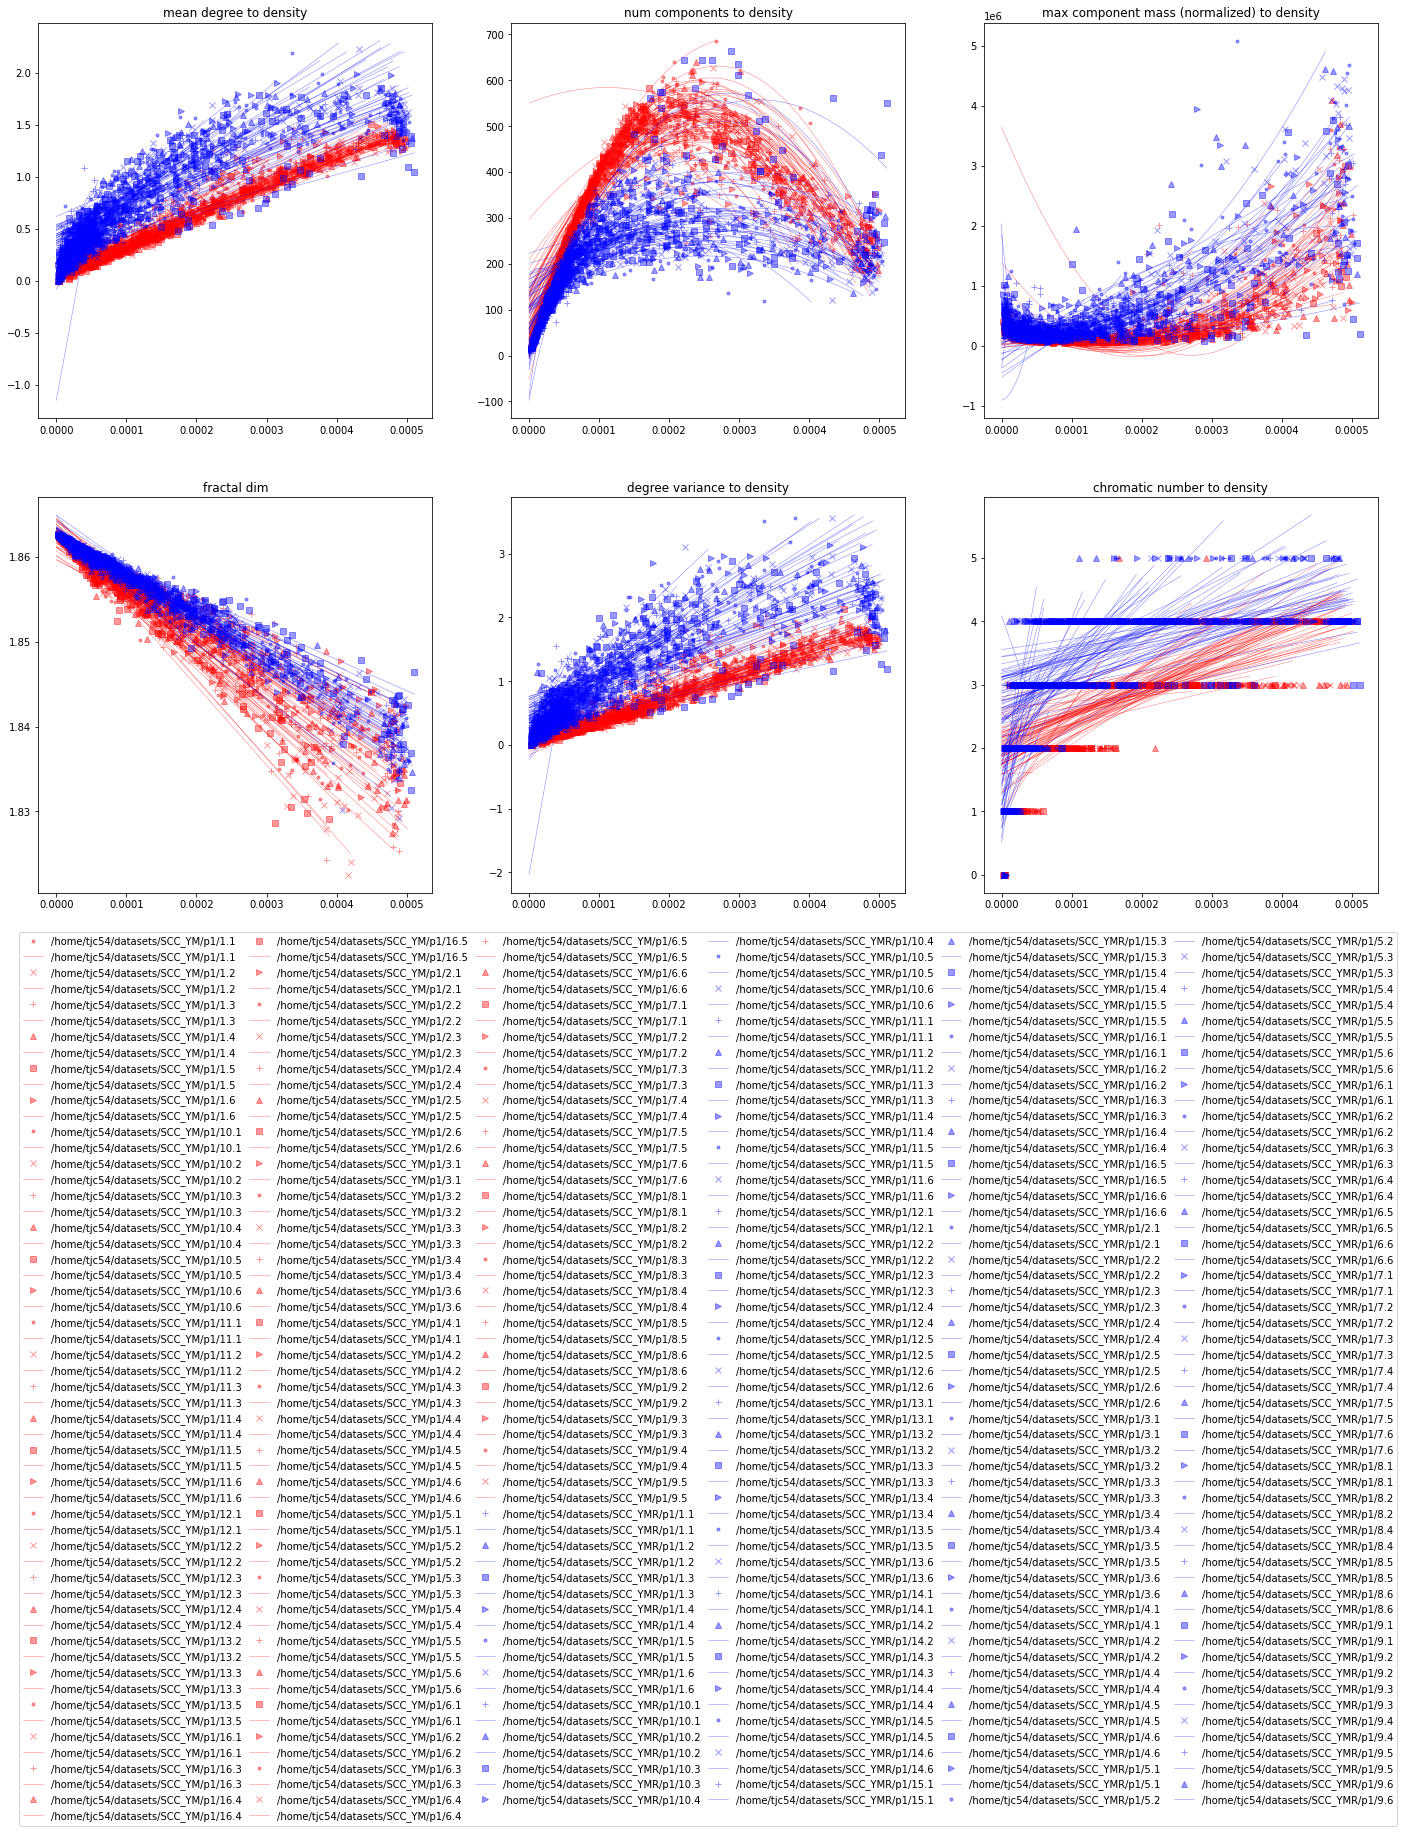

In [4]:
import itertools

plot = True

#if plot != False:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 16))
symbols = ['.','x','+','^','s','>']


#fitprops = []
objs = []
ncomp0 = []
ncomp1 = []
ncomp2 = []
mdeg0 = []
mdeg1 = []
mcompmass0 = []
mcompmass1 = []
mcompmass2 = []
fdim0 = []
fdim1 = []
cnum0 = []
cnum1 = []
degvar0 = []
degvar1 = []


def polyfit_rough(xdata,ydata,pdegree = 1, plot = False, axes = None, color = None, label = "Fit function"):
    popt = np.polyfit(xdata, ydata, pdegree)#---------------------------------
    if plot != False:
        t = np.linspace(0, max(xdata), 1000)
        axes.plot(t, np.poly1d(popt)(t), label=label, color = color, linewidth = .5, alpha = 0.5)
    return popt

i = 0
ax1.set_title("mean degree to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    degree = [network.average_degree() for network in lineage.items]

    degree = [degree for _,degree in sorted(zip(density,degree))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax1.plot(density,degree, symbols[i%6], label = lineage.tag, color = color, alpha = 0.4)
    
    temp = polyfit_rough(density,degree,pdegree=1,axes = ax1, color = color, label = lineage.tag, plot = plot)
    mdeg0.append(temp[0])
    mdeg1.append(temp[1])
    i += 1
#ax1.legend()

i = 0
ax2.set_title("num components to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    num_components = [network.num_components for network in lineage.items]

    num_components = [num_components for _,num_components in sorted(zip(density,num_components))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax2.plot(density,num_components, symbols[i%6], label = lineage.tag, color = color, alpha = 0.4)
    
    temp = polyfit_rough(density,num_components,pdegree=2,axes = ax2, color = color, label = lineage.tag, plot = plot)
    ncomp0.append(temp[0])
    ncomp1.append(temp[1])
    ncomp2.append(temp[2])
    i += 1
#ax2.legend()

i = 0
ax3.set_title("max component mass (normalized) to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    max_mass = [network.get_max_comp_mass() for network in lineage.items]

    max_mass = [max_mass for _,max_mass in sorted(zip(density,max_mass))]
    density = sorted(density)
    
    max_mass = np.divide(max_mass,density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax3.plot(density,max_mass, symbols[i%6], label = lineage.tag, color = color, alpha = 0.4)
    
    temp = polyfit_rough(density,max_mass,pdegree=2,axes = ax3, color = color, label = lineage.tag, plot = plot)
    mcompmass0.append(temp[0])
    mcompmass1.append(temp[1])
    mcompmass2.append(temp[2])
    i += 1
#ax3.legend()

i = 0
ax4.set_title("fractal dim")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    fractal_dim = [network.fractal_dim for network in lineage.items]

    fractal_dim = [fractal_dim for _,fractal_dim in sorted(zip(density,fractal_dim))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax4.plot(density,fractal_dim, symbols[i%6], label = lineage.tag, color = color, alpha = 0.4)
    
    temp = polyfit_rough(density,fractal_dim,pdegree=1,axes = ax4, color = color, label = lineage.tag, plot = plot)
    fdim0.append(temp[0])
    fdim1.append(temp[1])
    i += 1
#ax4.legend()

i = 0
ax5.set_title("degree variance to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    degree_var = [network.degree_variance() for network in lineage.items]

    degree_var = [degree_var for _,degree_var in sorted(zip(density,degree_var))]
    density = sorted(density)
    
    #degree_var = np.divide(degree_var,density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax5.plot(density,degree_var, symbols[i%6], label = lineage.tag, color = color, alpha = 0.4)
    
    temp = polyfit_rough(density,degree_var,pdegree=1,axes = ax5, color = color, label = lineage.tag, plot = plot)
    degvar0.append(temp[0])
    degvar1.append(temp[1])
    i += 1
ax5.legend(bbox_to_anchor=(-1.25, 0, 3.5, -.1), ncol=6, mode="expand", borderaxespad=0.)

i = 0
ax6.set_title("chromatic number to density")
for lineage in lineage_list:
    #tqdm(lineage_list, desc = "chromatic number", position=0, leave=True):
    density = [network.density for network in lineage.items]
    colornum = [network.calc_chromatic() for network in lineage.items]

    colornum = [colornum for _,colornum in sorted(zip(density,colornum))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    if "YM/" in lineage.tag:
        color = "r"
    if "YMR/" in lineage.tag:
        color = "b"
    ax6.plot(density,colornum, symbols[i%6], label = lineage.tag, color = color, alpha = 0.4)
    
    temp = polyfit_rough(density,colornum,pdegree=1,axes = ax6, color = color, label = lineage.tag, plot = plot)
    cnum0.append(temp[0])
    cnum1.append(temp[1])
    i += 1
#ax6.legend()

plt.savefig("densityPlots_YM+YMR.png", dpi = 75)

In [5]:
#///   LOAD TO PANDAS DF   ///#

import pandas as pd
'''
each lineage has:

lineage

3 fit params for num components:
    ncomp0 ncomp1 ncomp2
    
2 fit params for mean degree (normalized):
    mdeg0 mdeg1
    
3 fit params for max comp mass (normalized):
    mcompmass0 mcompmass1 mcompmass2
    
2 fit params for fractal dimension:
    fdim0 fdim1
    
2 fit params for chromatic number:
    cnum0 cnum1
    
2 fit params for degree variance:
    degvar0 degvar1
    
'''

#Creating the dataframe

l_tags = [lineage.tag for lineage in lineage_list]


objs = {
    'lineage':l_tags,
    'ncomp0':ncomp0,
    'ncomp1':ncomp1, 
    'ncomp2':ncomp2, 
    'mdeg0':mdeg0, 
    'mdeg1':mdeg1, 
    'mcompmass0':mcompmass0, 
    'mcompmass1':mcompmass1, 
    'mcompmass2':mcompmass2, 
    'fdim0':fdim0, 
    'fdim1':fdim1, 
    'cnum0':cnum0, 
    'cnum1':cnum1, 
    'degvar0':degvar0, 
    'degvar1':degvar1,
}

'''
Additional OBJS:

num components apex:
    ncomph = -ncomp1/(2*ncomp0)
    ncompk = ncomp2 - (ncomp1*ncomp1/(4*ncomp0))

numcomp
'''
add_objs = {
    
    
    
}

def choose_color(lineage):
    if "YM/" in lineage:
        return "r"
    if "YMR/" in lineage:
        return "b"
    
df = pd.DataFrame(objs)
df['line'] = [choose_color(lineage[0]) for lineage in y]


In [12]:
#///   PCA   ///#

#Property Standardization

features = ['ncomp0', 'ncomp1', 'ncomp2', 
           'mdeg0', 'mdeg1', 
           'mcompmass0', 'mcompmass1', 'mcompmass2', 
           'fdim0', 'fdim1', 
           'cnum0', 'cnum1', 
           'degvar0', 'degvar1']

x = df.loc[:, features].values
y = df.loc[:,['lineage']].values
x = StandardScaler().fit_transform(x)

#PCA Projection

pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4'])

finalDf = pd.concat([principalDf, df[['lineage']]], axis = 1)

EVR = pca.explained_variance_ratio_

print(EVR)
print(sum(EVR))

[0.27948255 0.18111089 0.13015087 0.11549944]
0.7062437546772186


100%|██████████| 360/360 [06:46<00:00,  1.13s/it]


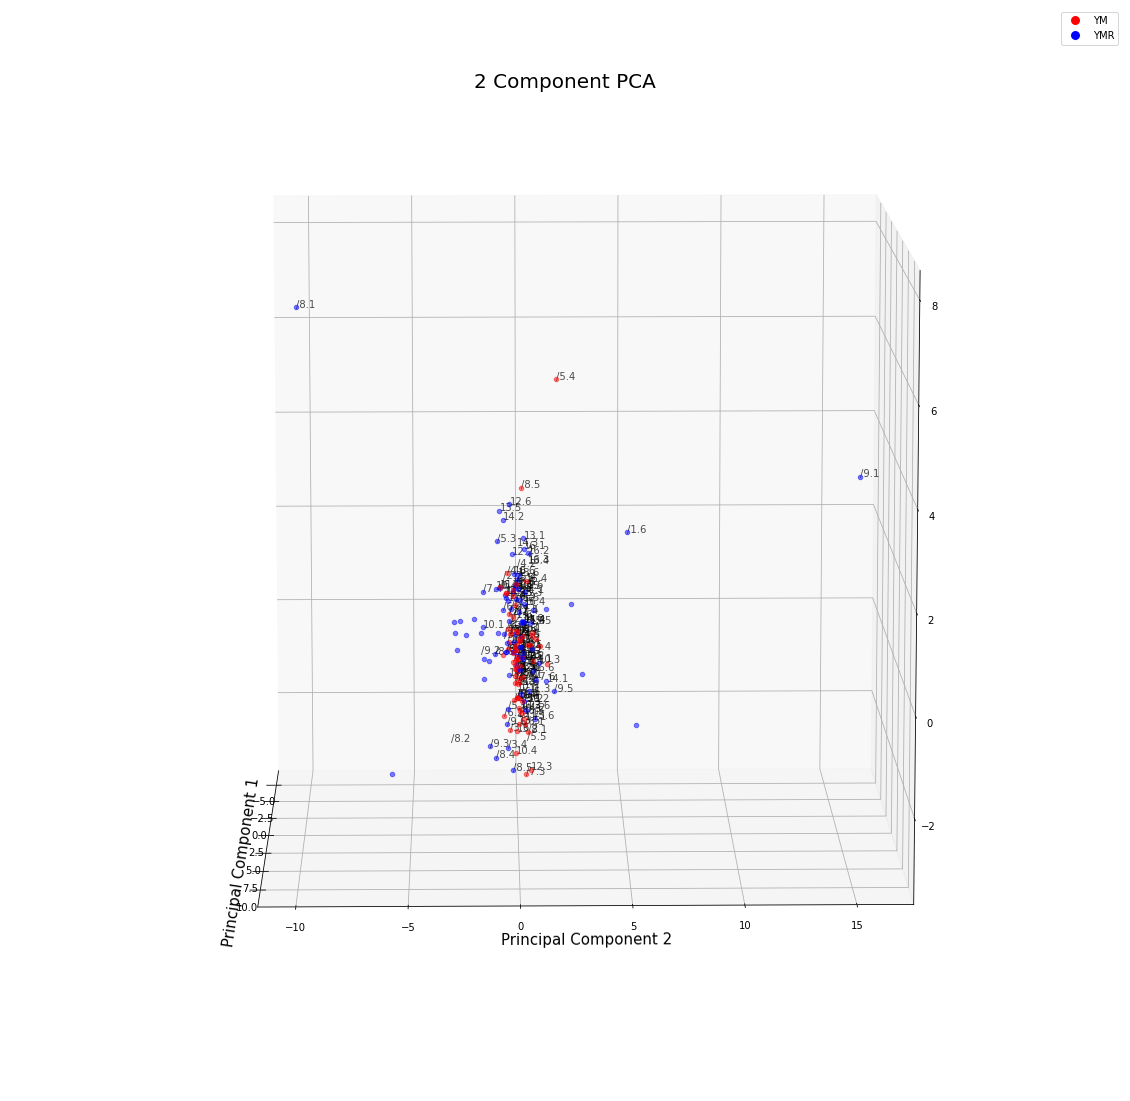

In [25]:
from mpl_toolkits import mplot3d
from matplotlib.lines import Line2D

#Visualizer

#fig, ax1 = plt.subplots(1, 1, figsize=(30, 8))
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(111, projection='3d')

ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_zlabel('Principal Component 3', fontsize = 15)
ax1.set_title('3 Component PCA', fontsize = 20)


symbols = ['.','x','+','^','o',]

for i in range(len(finalDf)):
    indicesToKeep = finalDf['lineage'] == lineage
    #color=next(ax6._get_lines.prop_cycler)['color']
    if "YM/" in finalDf.at[i, 'lineage']:
        color = "r"
    if "YMR/" in finalDf.at[i, 'lineage']:
        color = "b"
    ax1.scatter3D(finalDf.at[i, 'pc1']
          , finalDf.at[i, 'pc2']
          , finalDf.at[i, 'pc3']
          , symbols[i%5], color = color
          , alpha = 0.5)
    ax1.text(finalDf.at[i, 'pc1'],finalDf.at[i, 'pc2'],finalDf.at[i, 'pc3'] ,  finalDf.at[i,'lineage'][-4:], size=10, alpha = 0.7,  color='k') 

    
legend_elements = [Line2D([0], [0], marker='o', color='w', label='YM',
                          markerfacecolor='r', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='YMR',
                          markerfacecolor='b', markersize=10),]
ax1.legend(handles=legend_elements)
    
    
    
for ii in tqdm(range(0,360,1)):
    ax1.view_init(elev=10., azim=ii)
    plt.savefig("movie/movie%d.png" % ii)
        
#plt.savefig("2 Component PCA.png", dpi = 75)

In [26]:
#///   TSNE   ///#

from sklearn.manifold import TSNE

#tsne_pre_df = pd.DataFrame()
features = ['ncomp0', 'ncomp1', 'ncomp2', 
           'mdeg0', 'mdeg1', 
           'mcompmass0', 'mcompmass1', 'mcompmass2', 
           'fdim0', 'fdim1', 
           'cnum0', 'cnum1', 
           'degvar0', 'degvar1']

tsne_pre_df = pd.DataFrame()
tsne_pre_df = pd.concat([df[features]], axis = 1)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(tsne_pre_df)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 166 samples in 0.002s...
[t-SNE] Computed neighbors for 166 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 166 / 166
[t-SNE] Mean sigma: 2673662096235.540039
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.369347
[t-SNE] KL divergence after 300 iterations: 0.198037


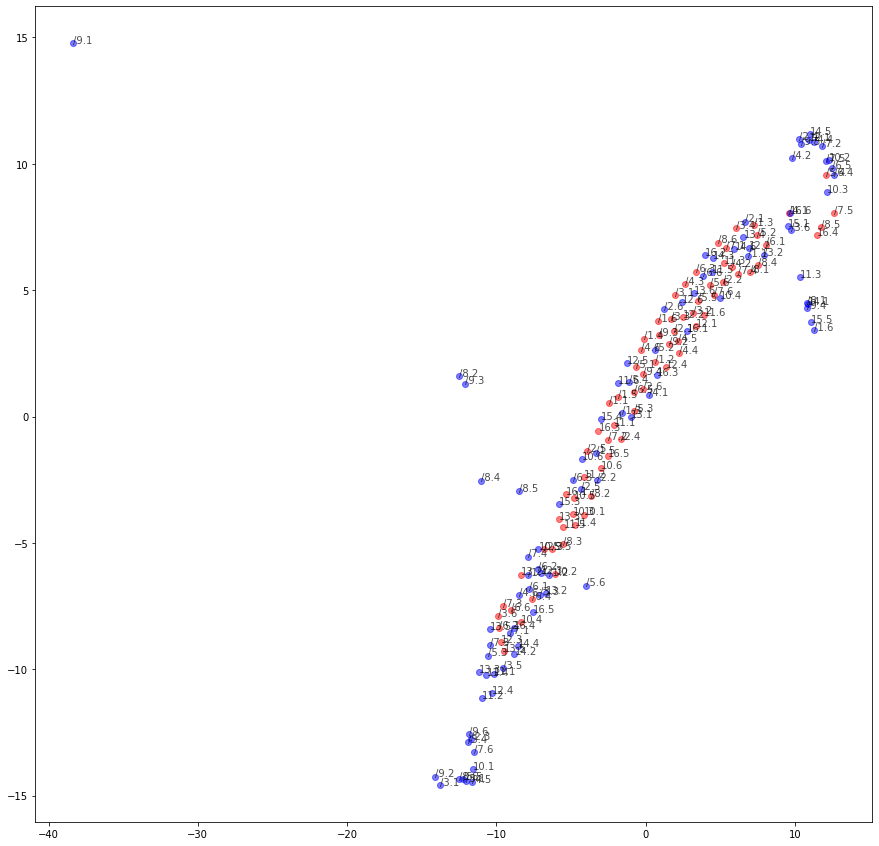

In [40]:
def choose_color(lineage):
    if "YM/" in lineage:
        return "r"
    if "YMR/" in lineage:
        return "b"


tsne_df = pd.DataFrame()
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df = pd.concat([tsne_df, df[['lineage']]], axis = 1)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(111)


for i in range(len(tsne_df)):
    indicesToKeep = tsne_df['lineage'] == lineage
    if "YM/" in tsne_df.at[i, 'lineage']:
        color = "r"
    if "YMR/" in tsne_df.at[i, 'lineage']:
        color = "b"
    ax1.scatter(tsne_df.at[i, 'tsne-2d-one']
          , tsne_df.at[i, 'tsne-2d-two']
          , color = color
          , alpha = 0.5)
    ax1.text(tsne_df.at[i, 'tsne-2d-one'],tsne_df.at[i, 'tsne-2d-two'], tsne_df.at[i,'lineage'][-4:], size=10, alpha = 0.7,  color='k') 


In [32]:
tsne_df.at[0,'lineage']

'/home/tjc54/datasets/SCC_YM/p1/1.1'

In [66]:
#///   UMAP   ///#

import umap

#FOR out dimensionality
n_components = 3

reducer = umap.UMAP(n_components = n_components)

#Property Standardization

features = ['ncomp0', 'ncomp1', 'ncomp2', 
           'mdeg0', 'mdeg1', 
           'mcompmass0', 'mcompmass1', 'mcompmass2', 
           'fdim0', 'fdim1', 
           'cnum0', 'cnum1', 
           'degvar0', 'degvar1']


x = df.loc[:, features].values
y = df.loc[:,['lineage']].values
df['line'] = [choose_color(lineage[0]) for lineage in y]
x = StandardScaler().fit_transform(x)

embedding = reducer.fit_transform(x)
embedding.shape

(166, 2)

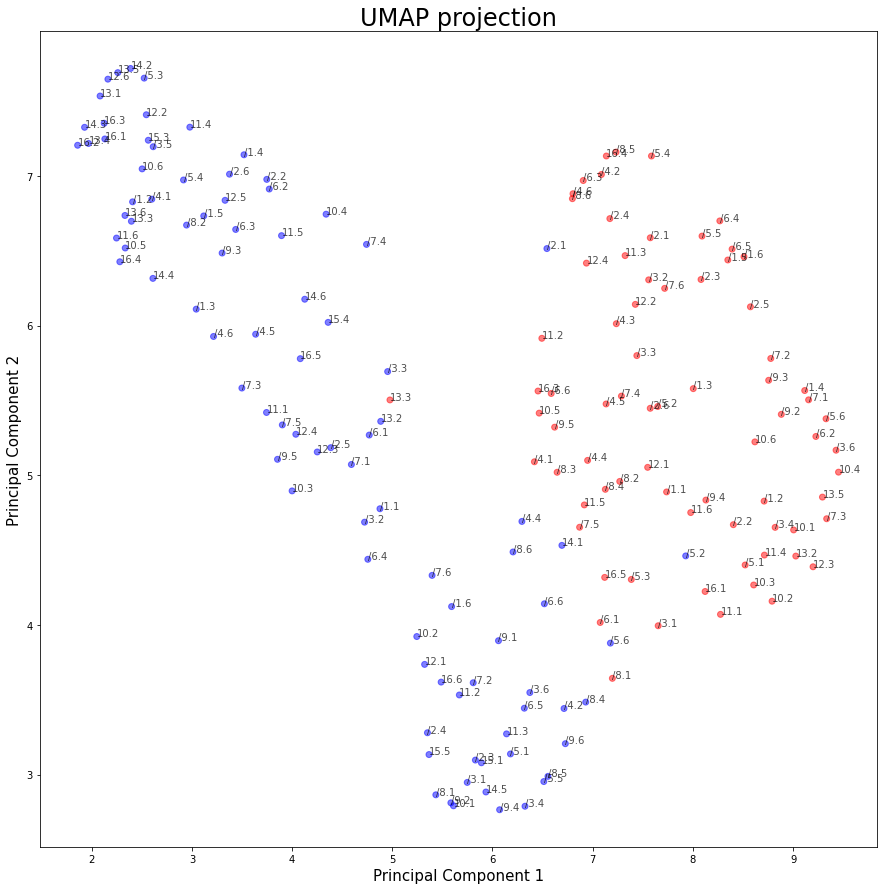

In [75]:
def choose_color(lineage):
    if "YM/" in lineage:
        return "r"
    if "YMR/" in lineage:
        return "b"

if n_components == 2:
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(111)

    ax1.set_xlabel('umap 1', fontsize = 15)
    ax1.set_ylabel('umap 2', fontsize = 15)
    ax1.set_title('UMAP projection', fontsize=24)

    ax1.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=[choose_color(lineage[0]) for lineage in y],
        alpha = 0.5)
    for i in range(len(embedding)):
        ax1.text(embedding[i][0],embedding[i][1], df['lineage'][i][-4:], size=10, alpha = 0.7,  color='k') 

if n_components == 3:
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(111, projection='3d')

    ax1.set_xlabel('umap 1', fontsize = 15)
    ax1.set_ylabel('umap 2', fontsize = 15)
    ax1.set_zlabel('umap 3', fontsize = 15)
    ax1.set_title('UMAP projection', fontsize=24)

    ax1.scatter(
        embedding[:, 0],
        embedding[:, 1],
        embedding[:, 2],
        c=[choose_color(lineage[0]) for lineage in y],
        alpha = 0.5)
    for i in range(len(embedding)):
        ax1.text(embedding[i][0],embedding[i][1],embedding[i][2], df['lineage'][i][-4:], size=10, alpha = 0.7,  color='k') 


In [ ]:
sns.pairplot(df, hue='line', plot_kws={'scatter_kws': {'alpha': 0.2}})